LDA 분석 / RNN (통계적 기법과 딥러닝의 비교)

In [34]:
# !pip install -q scikit-learn==1.0.0
# !pip install -U -q pyLDAvis==3.4.0

In [1]:
#LDA 분석 // RNN (통계적 기법과 딥러닝 비교)
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
raw = pd.read_csv("https://raw.githubusercontent.com/corazzon/web_scraping/master/seoul-120/seoul-120-text.csv")

In [4]:
df = raw.copy()

In [5]:
df = df.dropna()

In [6]:
df.head()

번호  분류                           제목  \
0  2645  복지                  아빠 육아휴직 장려금   
1  2644  경제            [서울산업진흥원] 서울메이드란?   
2  2643  환경                    (강북구) 정비중   
3  2642  복지  광진맘택시 운영(임산부,영아 양육가정 전용 택시)   
4  2641  복지               마포 뇌병변장애인 비전센터   

                                                  내용      내용번호  
0  아빠 육아휴직 장려금   업무개요  남성근로자의 육아휴직을 장려하고 양육에 따른 경...  23522464  
1  서울산업진흥원 서울메이드란 서울의 감성을 담은 다양하고 새로운 경험을 제공하기 위해...  23194045  
2  강북구 정비중  업무개요  투명 폐트병을 교환보상하므로 수거율을 높이고 폐기물을 감...  23032485  
3  광진맘택시 운영임산부영아 양육가정 전용 택시  업무개요 교통약자인 임산부와 영아가정...  22904492  
4  마포 뇌병변장애인 비전센터 마포뇌병변장애인 비전센터 운영   구분 내용  목적  학...  22477798

In [7]:
df.shape

(2645, 5)

In [8]:
#결측치 여부 확인
df.isnull().sum()

번호      0
분류      0
제목      0
내용      0
내용번호    0
dtype: int64

In [9]:
#문서(document) 만들기
# cf, RNN, LSTM, Tramsformer --> 이렇게 3개가 실무에서 많이 쓰임

df.columns

Index(['번호', '분류', '제목', '내용', '내용번호'], dtype='object')

In [10]:
#텍스트 데이터를 한번에 전처리 하기 위해서
df['문서'] = df['제목'] + " " + df['내용']

In [11]:
df.head()

번호  분류                           제목  \
0  2645  복지                  아빠 육아휴직 장려금   
1  2644  경제            [서울산업진흥원] 서울메이드란?   
2  2643  환경                    (강북구) 정비중   
3  2642  복지  광진맘택시 운영(임산부,영아 양육가정 전용 택시)   
4  2641  복지               마포 뇌병변장애인 비전센터   

                                                  내용      내용번호  \
0  아빠 육아휴직 장려금   업무개요  남성근로자의 육아휴직을 장려하고 양육에 따른 경...  23522464   
1  서울산업진흥원 서울메이드란 서울의 감성을 담은 다양하고 새로운 경험을 제공하기 위해...  23194045   
2  강북구 정비중  업무개요  투명 폐트병을 교환보상하므로 수거율을 높이고 폐기물을 감...  23032485   
3  광진맘택시 운영임산부영아 양육가정 전용 택시  업무개요 교통약자인 임산부와 영아가정...  22904492   
4  마포 뇌병변장애인 비전센터 마포뇌병변장애인 비전센터 운영   구분 내용  목적  학...  22477798   

                                                  문서  
0  아빠 육아휴직 장려금 아빠 육아휴직 장려금   업무개요  남성근로자의 육아휴직을 장...  
1  [서울산업진흥원] 서울메이드란? 서울산업진흥원 서울메이드란 서울의 감성을 담은 다양...  
2  (강북구) 정비중 강북구 정비중  업무개요  투명 폐트병을 교환보상하므로 수거율을 ...  
3  광진맘택시 운영(임산부,영아 양육가정 전용 택시) 광진맘택시 운영임산부영아 양육가정...  
4  마포 뇌병변장애인 비전센터 마포 뇌병변장애인 비전센터 마포뇌병변장애인 비전센터 운영...

전처리

In [12]:
#countvectorizer

'''
* analyzer : 단어, 문자 단위의 벡터화 방법 정의

* ngram_range : BOW 단위 수 (1, 3) 이라면 1개~3개까지 토큰을 묶어서 벡터화

* max_df : 어휘를 작성할 때 문서 빈도가 주어진 임계값보다 높은 용어(말뭉치 관련 불용어)는 제외 (기본값=1.0)
    * max_df = 0.90 : 문서의 90% 이상에 나타나는 단어 제외
    * max_df = 10 : 10개 이상의 문서에 나타나는 단어 제외

* min_df : 어휘를 작성할 때 문서 빈도가 주어진 임계값보다 낮은 용어는 제외합니다. 컷오프라고도 합니다.(기본값=1.0)
    * min_df = 0.01 : 문서의 1% 미만으로 나타나는 단어 제외
    * min_df = 10 : 문서에 10개 미만으로 나타나는 단어 제외

* stop_words : 불용어 정의

* API Document: https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html
'''

'\n* analyzer : 단어, 문자 단위의 벡터화 방법 정의\n\n* ngram_range : BOW 단위 수 (1, 3) 이라면 1개~3개까지 토큰을 묶어서 벡터화\n\n* max_df : 어휘를 작성할 때 문서 빈도가 주어진 임계값보다 높은 용어(말뭉치 관련 불용어)는 제외 (기본값=1.0)\n    * max_df = 0.90 : 문서의 90% 이상에 나타나는 단어 제외\n    * max_df = 10 : 10개 이상의 문서에 나타나는 단어 제외\n\n* min_df : 어휘를 작성할 때 문서 빈도가 주어진 임계값보다 낮은 용어는 제외합니다. 컷오프라고도 합니다.(기본값=1.0)\n    * min_df = 0.01 : 문서의 1% 미만으로 나타나는 단어 제외\n    * min_df = 10 : 문서에 10개 미만으로 나타나는 단어 제외\n\n* stop_words : 불용어 정의\n\n* API Document: https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html\n'

In [13]:
# 단어의 출현 빈도(Frequency)로 여러 문서들을 벡터화(숫자화)

from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(stop_words = ['돋움','경우','또는'])

In [14]:
# fit() : 문서 >> 문서의 모든 토큰의 어휘 사전(vocab) 학습
# transform() : 어휘 사전(vocab) 학습 후, dtm(document term matrix) (숫자 형태로 변경)

dtm_cv = cv.fit_transform(df['문서'])

In [15]:
dtm_cv

<2645x56651 sparse matrix of type '<class 'numpy.int64'>'
	with 118578 stored elements in Compressed Sparse Row format>

In [16]:
dtm_cv.toarray()

# Sparse Matrix(희소행렬)() 행렬값이 대부분 0인 행렬 >> 배열로 변경

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [17]:
cv.vocabulary_

{'아빠': 30166,
 '육아휴직': 35794,
 '장려금': 40098,
 '업무개요': 31494,
 '남성근로자의': 9780,
 '육아휴직을': 35798,
 '장려하고': 40101,
 '양육에': 31079,
 '따른': 14184,
 '경제적': 3650,
 '부담을': 20458,
 '완화함으로써': 33605,
 '일과': 37802,
 '가정생활의': 694,
 '양립': 31009,
 '가족친화적인': 784,
 '사회환경': 22911,
 '조성': 43603,
 '지원대상': 46358,
 '신청일': 29324,
 '기준': 8969,
 '이상': 36691,
 '계속하여': 3781,
 '서초구에': 24773,
 '주민등록': 44417,
 '되어': 13584,
 '있는': 38959,
 '육아휴직자': 35799,
 '대상자녀': 11880,
 '신청기간': 29232,
 '시작일': 28426,
 '이후': 37282,
 '개월부터': 1767,
 '종료일': 44002,
 '개월': 1753,
 '이내': 36439,
 '신청방법': 29260,
 '온라인': 33390,
 '서초구청': 24776,
 '홈페이지': 55328,
 '경로': 3421,
 '분야별정보': 21117,
 '복지': 20129,
 '영유아복지': 32834,
 '아빠육아휴직장려금': 30170,
 '신청': 29215,
 '바로가기': 17408,
 '방문': 18118,
 '동주민센터': 13431,
 '여성보육과': 31951,
 '구비서류': 6902,
 '고용센터': 4208,
 '발행': 18048,
 '육아휴직급여': 35795,
 '지급결정': 45803,
 '통지서': 51047,
 '주민등록등본': 44419,
 '부세대원': 20662,
 '이름과': 36609,
 '전입일자': 41564,
 '포함': 52225,
 '모든': 15657,
 '구성원': 6951,
 '주민번호': 44460,
 '뒷자리': 13756,
 '

In [18]:
print(cv.vocabulary_)


{'아빠': 30166, '육아휴직': 35794, '장려금': 40098, '업무개요': 31494, '남성근로자의': 9780, '육아휴직을': 35798, '장려하고': 40101, '양육에': 31079, '따른': 14184, '경제적': 3650, '부담을': 20458, '완화함으로써': 33605, '일과': 37802, '가정생활의': 694, '양립': 31009, '가족친화적인': 784, '사회환경': 22911, '조성': 43603, '지원대상': 46358, '신청일': 29324, '기준': 8969, '이상': 36691, '계속하여': 3781, '서초구에': 24773, '주민등록': 44417, '되어': 13584, '있는': 38959, '육아휴직자': 35799, '대상자녀': 11880, '신청기간': 29232, '시작일': 28426, '이후': 37282, '개월부터': 1767, '종료일': 44002, '개월': 1753, '이내': 36439, '신청방법': 29260, '온라인': 33390, '서초구청': 24776, '홈페이지': 55328, '경로': 3421, '분야별정보': 21117, '복지': 20129, '영유아복지': 32834, '아빠육아휴직장려금': 30170, '신청': 29215, '바로가기': 17408, '방문': 18118, '동주민센터': 13431, '여성보육과': 31951, '구비서류': 6902, '고용센터': 4208, '발행': 18048, '육아휴직급여': 35795, '지급결정': 45803, '통지서': 51047, '주민등록등본': 44419, '부세대원': 20662, '이름과': 36609, '전입일자': 41564, '포함': 52225, '모든': 15657, '구성원': 6951, '주민번호': 44460, '뒷자리': 13756, '미포함': 17033, '지원내용': 46353, '매월': 15105, '만원지원기간': 14790, '최대': 4

In [19]:
cv.get_feature_names_out()

array(['03월', '08년', '10', ..., '힘쓴다', '힘을', '힘이'], dtype=object)

In [20]:
cv_cols = cv.get_feature_names_out()
cv_cols


array(['03월', '08년', '10', ..., '힘쓴다', '힘을', '힘이'], dtype=object)

In [21]:
pd.DataFrame(dtm_cv.toarray(), columns = cv_cols)


03월  08년  10  100명이상인  100세가  10만원  10만원상당  10명이고  10인승  10인의  ...  \
0       0    0   0        0      0     0       0      0     0     0  ...   
1       0    0   0        0      0     0       0      0     0     0  ...   
2       0    0   0        0      0     0       0      0     0     0  ...   
3       0    0   0        0      0     0       0      0     0     0  ...   
4       0    0   0        0      0     0       0      0     0     0  ...   
...   ...  ...  ..      ...    ...   ...     ...    ...   ...   ...  ...   
2640    0    0   0        0      0     0       0      0     0     0  ...   
2641    0    0   0        0      0     0       0      0     0     0  ...   
2642    0    0   0        0      0     0       0      0     0     0  ...   
2643    0    0   0        0      0     0       0      0     0     0  ...   
2644    0    0   0        0      0     0       0      0     0     0  ...   

      힐링프로그램을  힐링하는  힐스테이트  힘들  힘들경우  힘들고  힘쓰고있습니다  힘쓴다  힘을  힘이  
0           0     0      0   0     0    0        0    0   0   0  
1           0     0      0   0     0    0        0    0   0   0  
2           0     0      0   0     0    0        0    0   0   0  
3           0     0      0   0     0    0        0    0   0   0  
4           0     0      0   0     0    0        0    0   0   0  
...       ...   ...    ...  ..   ...  ...      ...  ...  ..  ..  
2640        0     0      0   0     0    0        0    0   0   0  
2641        0     0      0   0     0    0        0    0   0   0  
2642        0     0      0   0     0    0        0    0   0   0  
2643        0     0      0   0     0    0        0    0   0   0  
2644        0     0      0   0     0    0        0    0   0   0  

[2645 rows x 56651 columns]

In [22]:
pd.DataFrame(dtm_cv.toarray(), columns = cv_cols).sum()

03월        1
08년        1
10         1
100명이상인    1
100세가      1
          ..
힘들고        1
힘쓰고있습니다    1
힘쓴다        1
힘을         2
힘이         1
Length: 56651, dtype: int64

In [23]:
pd.DataFrame(dtm_cv.toarray(), columns = cv_cols).sum().sort_values()


용역계약적격심사용역실적증명서      1
용수등                  1
용수로                  1
용액속에                 1
용액을                  1
                  ... 
대한                 394
서울시                578
어떻게                597
있습니다               685
있는                 718
Length: 56651, dtype: int64

잠재 디리클레 할당(LDA)

In [24]:
# 정답인 '분류'의 유일한 값 확인 >> 주제 수 확인
df.columns

Index(['번호', '분류', '제목', '내용', '내용번호', '문서'], dtype='object')

In [25]:
df['분류']


0           복지
1           경제
2           환경
3           복지
4           복지
         ...  
2640    주택도시계획
2641        환경
2642        복지
2643        교통
2644        환경
Name: 분류, Length: 2645, dtype: object

In [26]:
df['분류'].value_counts()


분류
행정        1098
경제         823
복지         217
환경         124
주택도시계획     110
문화관광        96
교통          90
안전          51
건강          23
여성가족        13
Name: count, dtype: int64

In [27]:
# LDA
# 주어진 문서(docs) >> 각 문서에 어떤 주제들이 존재하는지 확인
# n_components : 하이퍼 파라미터 >> 주제 수 설정
  # >> NUM-TOPICS (default : 10)
# max_iter : 훈련 데이터에 대한 최대 반복 수 (dafault = 10)
# 토픽모델링 기법중 하나
from sklearn.decomposition import LatentDirichletAllocation

num_topics = 10
lda = LatentDirichletAllocation(n_components = num_topics, random_state = 42)

In [28]:
#모델 학습
lda.fit(dtm_cv)

LatentDirichletAllocation(random_state=42)

In [31]:
!pip install pyLDAvis

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 17.9 MB/s eta 0:00:00


In [32]:
import pyLDAvis.lda_model

pyLDAvis.enable_notebook()
pyLDAvis.lda_model.prepare(lda, dtm_cv, cv, mds = 'tsne')


# mds : Multi-Dimentional-Scaling // 다차원 척도법
# 이게 바로 marketing에서 말하는 positioning (STP)

# TSNE : (특히 sns 분석할 때 많이 씀)
# T-stochastic Neighbor Embedding
# 고차원(다변량) 데이터를 2차원, 3차원으로 줄여서 가시화(차원축)

PreparedData(topic_coordinates=               x          y  topics  cluster       Freq
topic                                                  
3     -24.892687  -1.481847       1        1  13.259921
7      -7.114437  11.471320       2        1  11.412742
2     -16.142147  12.054690       3        1  11.228595
8     -23.683428  25.761868       4        1  10.144832
9     -33.120979  18.012659       5        1  10.043109
0     -23.911837  16.591885       6        1   9.877599
4     -13.656519  21.492458       7        1   9.539921
5     -23.946781   7.590266       8        1   9.012524
6     -33.315556   7.396611       9        1   8.086331
1     -14.417489   2.210603      10        1   7.394426, topic_info=        Term        Freq       Total Category  logprob  loglift
119      amp   63.000000   63.000000  Default  30.0000  30.0000
39480   자본금은   52.000000   52.000000  Default  29.0000  29.0000
36388     의한  205.000000  205.000000  Default  28.0000  28.0000
8795   기술능력과   34.000000   34.000000  Default  27.0000  27.0000
31204    어떻게  441.000000  441.000000  Default  26.0000  26.0000
...      ...         ...         ...      ...      ...      ...
53924    합니다   14.178559  196.194444  Topic10  -6.6828  -0.0229
3575    경우에는   13.916488  192.141237  Topic10  -6.7015  -0.0207
9077      기타   12.125611  120.348058  Topic10  -6.8392   0.3094
27828     시간   12.035864  115.813247  Topic10  -6.8467   0.3404
304       가능   12.074554  226.443098  Topic10  -6.8435  -0.3269

[749 rows x 6 columns], token_table=       Topic      Freq     Term
term                           
119        3  0.980964      amp
119        5  0.015822      amp
121        3  0.960074     apos
304        1  0.114819       가능
304        2  0.128067       가능
...      ...       ...      ...
56176     10  0.055042       회의
56308      7  0.924373  후계농업경영인
56375      1  0.208700       훈련
56375      5  0.730451       훈련
56375      7  0.104350       훈련

[1810 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 8, 3, 9, 10, 1, 5, 6, 7, 2])

In [33]:
# TF-IDF (term frequency, inverse document frequency)

# TfidfVectorizer

# norm = 'l2'
# norm : normalization >> 한 단위(unit)를 1로 만드는 것

# >> l1 : vector([1, 2, 3, ...]의 각 원소의 절대값의 합이 1, 크기 조절)
# >> l2 :  vector([1, 2, 3, ...]의 각 원소의 제곱의 합이 1, 크기 조절)

# l2를 선호하는 이유 : 미분이 가능하기 때문에


# smooth_idf = False
# >> feature 만들 때, '0'으로 나오는 항목에 대해 아주 작은 값을 더해서(smoothing)
# >> feature 만들지 아니면 그냥 생성할지 결정하는 것

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [35]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(stop_words = ['돋움','경우','또는', '있습니다', "있는", '합니다'])
tfidf

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


TfidfVectorizer(stop_words=['돋움', '경우', '또는', '있습니다', '있는', '합니다'])

In [36]:
#문장에서 노출되는 feature(특징이 될만한 단어)수를 합한 변수 dtm(document-term matrix) 생성
dtm_tfidf = tfidf.fit_transform(df['문서'])
dtm_tfidf

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<2645x56648 sparse matrix of type '<class 'numpy.float64'>'
	with 117379 stored elements in Compressed Sparse Row format>

In [37]:
print(tfidf.vocabulary_)

{'아빠': 30166, '육아휴직': 35794, '장려금': 40096, '업무개요': 31494, '남성근로자의': 9780, '육아휴직을': 35798, '장려하고': 40099, '양육에': 31079, '따른': 14184, '경제적': 3650, '부담을': 20458, '완화함으로써': 33605, '일과': 37802, '가정생활의': 694, '양립': 31009, '가족친화적인': 784, '사회환경': 22911, '조성': 43601, '지원대상': 46356, '신청일': 29324, '기준': 8969, '이상': 36691, '계속하여': 3781, '서초구에': 24773, '주민등록': 44415, '되어': 13584, '육아휴직자': 35799, '대상자녀': 11880, '신청기간': 29232, '시작일': 28426, '이후': 37282, '개월부터': 1767, '종료일': 44000, '개월': 1753, '이내': 36439, '신청방법': 29260, '온라인': 33390, '서초구청': 24776, '홈페이지': 55325, '경로': 3421, '분야별정보': 21117, '복지': 20129, '영유아복지': 32834, '아빠육아휴직장려금': 30170, '신청': 29215, '바로가기': 17408, '방문': 18118, '동주민센터': 13431, '여성보육과': 31951, '구비서류': 6902, '고용센터': 4208, '발행': 18048, '육아휴직급여': 35795, '지급결정': 45801, '통지서': 51045, '주민등록등본': 44417, '부세대원': 20662, '이름과': 36609, '전입일자': 41562, '포함': 52223, '모든': 15657, '구성원': 6951, '주민번호': 44458, '뒷자리': 13756, '미포함': 17033, '지원내용': 46351, '매월': 15105, '만원지원기간': 14790, '최대': 49173, '서울산업진흥

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [38]:
cols_tfidf = tfidf.get_feature_names_out()
cols_tfidf

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


array(['03월', '08년', '10', ..., '힘쓴다', '힘을', '힘이'], dtype=object)

In [39]:
dist = np.sum(dtm_tfidf, axis= 0 )
#dtm_tfidf를 axis=0(수직방향)기준, 합계를 낸 값

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [40]:
pd.DataFrame(dist, columns = cols_tfidf)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


03월       08년       10   100명이상인     100세가      10만원    10만원상당  \
0  0.150978  0.150978  0.17043  0.195757  0.192281  0.149478  0.185045   

      10명이고      10인승      10인의  ...   힐링프로그램을     힐링하는     힐스테이트        힘들  \
0  0.069138  0.093002  0.088388  ...  0.058174  0.07674  0.046929  0.155163   

      힘들경우      힘들고   힘쓰고있습니다      힘쓴다        힘을        힘이  
0  0.14922  0.14177  0.184454  0.04885  0.137309  0.047336  

[1 rows x 56648 columns]

In [41]:
pd.DataFrame(dist, columns = cols_tfidf).T


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


0
03월      0.150978
08년      0.150978
10       0.170430
100명이상인  0.195757
100세가    0.192281
...           ...
힘들고      0.141770
힘쓰고있습니다  0.184454
힘쓴다      0.048850
힘을       0.137309
힘이       0.047336

[56648 rows x 1 columns]

In [42]:
pd.DataFrame(dist, columns = cols_tfidf).T.sort_values(by = 0)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


0
농수산물공판장   0.010929
폐차영업소     0.010929
마을공동작업소   0.010929
마을공동회장    0.010929
분류되지      0.010929
...            ...
따라       16.652594
대한       18.866037
있나요      19.707343
서울시      22.586695
어떻게      37.924574

[56648 rows x 1 columns]

In [43]:
dtm_tfidf.toarray()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [44]:
pd.DataFrame(dtm_tfidf.toarray(), columns = cols_tfidf)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


03월  08년   10  100명이상인  100세가  10만원  10만원상당  10명이고  10인승  10인의  ...  \
0     0.0  0.0  0.0      0.0    0.0   0.0     0.0    0.0   0.0   0.0  ...   
1     0.0  0.0  0.0      0.0    0.0   0.0     0.0    0.0   0.0   0.0  ...   
2     0.0  0.0  0.0      0.0    0.0   0.0     0.0    0.0   0.0   0.0  ...   
3     0.0  0.0  0.0      0.0    0.0   0.0     0.0    0.0   0.0   0.0  ...   
4     0.0  0.0  0.0      0.0    0.0   0.0     0.0    0.0   0.0   0.0  ...   
...   ...  ...  ...      ...    ...   ...     ...    ...   ...   ...  ...   
2640  0.0  0.0  0.0      0.0    0.0   0.0     0.0    0.0   0.0   0.0  ...   
2641  0.0  0.0  0.0      0.0    0.0   0.0     0.0    0.0   0.0   0.0  ...   
2642  0.0  0.0  0.0      0.0    0.0   0.0     0.0    0.0   0.0   0.0  ...   
2643  0.0  0.0  0.0      0.0    0.0   0.0     0.0    0.0   0.0   0.0  ...   
2644  0.0  0.0  0.0      0.0    0.0   0.0     0.0    0.0   0.0   0.0  ...   

      힐링프로그램을  힐링하는  힐스테이트   힘들  힘들경우  힘들고  힘쓰고있습니다  힘쓴다   힘을   힘이  
0         0.0   0.0    0.0  0.0   0.0  0.0      0.0  0.0  0.0  0.0  
1         0.0   0.0    0.0  0.0   0.0  0.0      0.0  0.0  0.0  0.0  
2         0.0   0.0    0.0  0.0   0.0  0.0      0.0  0.0  0.0  0.0  
3         0.0   0.0    0.0  0.0   0.0  0.0      0.0  0.0  0.0  0.0  
4         0.0   0.0    0.0  0.0   0.0  0.0      0.0  0.0  0.0  0.0  
...       ...   ...    ...  ...   ...  ...      ...  ...  ...  ...  
2640      0.0   0.0    0.0  0.0   0.0  0.0      0.0  0.0  0.0  0.0  
2641      0.0   0.0    0.0  0.0   0.0  0.0      0.0  0.0  0.0  0.0  
2642      0.0   0.0    0.0  0.0   0.0  0.0      0.0  0.0  0.0  0.0  
2643      0.0   0.0    0.0  0.0   0.0  0.0      0.0  0.0  0.0  0.0  
2644      0.0   0.0    0.0  0.0   0.0  0.0      0.0  0.0  0.0  0.0  

[2645 rows x 56648 columns]

코사인 유사도

In [47]:
dtm_tfidf

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<2645x56648 sparse matrix of type '<class 'numpy.float64'>'
	with 117379 stored elements in Compressed Sparse Row format>

In [45]:
dtm_tfidf[0]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<1x56648 sparse matrix of type '<class 'numpy.float64'>'
	with 69 stored elements in Compressed Sparse Row format>

In [46]:
#코사인 유사도

from sklearn.metrics.pairwise import cosine_similarity

similarity_simple_pair = cosine_similarity(dtm_tfidf[0], dtm_tfidf)

# > 첫 번째 문서와 행렬 내 모든 문서 간의 코사인 유사도 계산

# dtm_tfidf[0] : dtm_tfidf 행렬의 첫번째 문서 >> 여러 개의 문서 단어집 중 첫 번째 문서 단어집

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [48]:
similarity_simple_pair

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


array([[1.        , 0.        , 0.00992368, ..., 0.        , 0.        ,
        0.        ]])

In [49]:
print(similarity_simple_pair.tolist())


[[1.0000000000000002, 0.0, 0.009923678841957669, 0.048404108116308873, 0.02025574051753766, 0.018545785241345206, 0.007689200514538418, 0.018522083190486933, 0.004388306893623127, 0.015596366271907504, 0.006417818542155355, 0.004801755890490625, 0.022530745285606658, 0.010670974912200712, 0.005465729535177705, 0.007180867167060432, 0.0, 0.007191459219804235, 0.0, 0.005548948853251886, 0.0, 0.014999956175567448, 0.01346177710130626, 0.03186585941980267, 0.006324895844168198, 0.011305577503097432, 0.010427219647652173, 0.002710780674870425, 0.028116213960632772, 0.019457084907946072, 0.009451308855535754, 0.0, 0.0, 0.003921239868317876, 0.03577777313658563, 0.046036608790211916, 0.0021097618250367598, 0.002429415475842774, 0.013110061818089996, 0.014356080256311333, 0.006058250439663024, 0.0025792085469002572, 0.0063704136642745305, 0.002651940481557007, 0.0, 0.005011121517701423, 0.0023776213006352406, 0.0, 0.01720119709846449, 0.0059659515845326225, 0.011601348999286984, 0.013632532682

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [50]:
print(similarity_simple_pair.tolist()[0])


[1.0000000000000002, 0.0, 0.009923678841957669, 0.048404108116308873, 0.02025574051753766, 0.018545785241345206, 0.007689200514538418, 0.018522083190486933, 0.004388306893623127, 0.015596366271907504, 0.006417818542155355, 0.004801755890490625, 0.022530745285606658, 0.010670974912200712, 0.005465729535177705, 0.007180867167060432, 0.0, 0.007191459219804235, 0.0, 0.005548948853251886, 0.0, 0.014999956175567448, 0.01346177710130626, 0.03186585941980267, 0.006324895844168198, 0.011305577503097432, 0.010427219647652173, 0.002710780674870425, 0.028116213960632772, 0.019457084907946072, 0.009451308855535754, 0.0, 0.0, 0.003921239868317876, 0.03577777313658563, 0.046036608790211916, 0.0021097618250367598, 0.002429415475842774, 0.013110061818089996, 0.014356080256311333, 0.006058250439663024, 0.0025792085469002572, 0.0063704136642745305, 0.002651940481557007, 0.0, 0.005011121517701423, 0.0023776213006352406, 0.0, 0.01720119709846449, 0.0059659515845326225, 0.011601348999286984, 0.0136325326822

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [51]:
result_list = similarity_simple_pair.tolist()[0]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [52]:
df['유사도(코사인)'] = result_list

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [53]:
df.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


번호  분류                           제목  \
0  2645  복지                  아빠 육아휴직 장려금   
1  2644  경제            [서울산업진흥원] 서울메이드란?   
2  2643  환경                    (강북구) 정비중   
3  2642  복지  광진맘택시 운영(임산부,영아 양육가정 전용 택시)   
4  2641  복지               마포 뇌병변장애인 비전센터   

                                                  내용      내용번호  \
0  아빠 육아휴직 장려금   업무개요  남성근로자의 육아휴직을 장려하고 양육에 따른 경...  23522464   
1  서울산업진흥원 서울메이드란 서울의 감성을 담은 다양하고 새로운 경험을 제공하기 위해...  23194045   
2  강북구 정비중  업무개요  투명 폐트병을 교환보상하므로 수거율을 높이고 폐기물을 감...  23032485   
3  광진맘택시 운영임산부영아 양육가정 전용 택시  업무개요 교통약자인 임산부와 영아가정...  22904492   
4  마포 뇌병변장애인 비전센터 마포뇌병변장애인 비전센터 운영   구분 내용  목적  학...  22477798   

                                                  문서  유사도(코사인)  
0  아빠 육아휴직 장려금 아빠 육아휴직 장려금   업무개요  남성근로자의 육아휴직을 장...  1.000000  
1  [서울산업진흥원] 서울메이드란? 서울산업진흥원 서울메이드란 서울의 감성을 담은 다양...  0.000000  
2  (강북구) 정비중 강북구 정비중  업무개요  투명 폐트병을 교환보상하므로 수거율을 ...  0.009924  
3  광진맘택시 운영(임산부,영아 양육가정 전용 택시) 광진맘택시 운영임산부영아 양육가정...  0.048404  
4  마포 뇌병변장애인 비전센터 마포 뇌병변장애인 비전센터 마포뇌병변장애인 비전센터 운영...  0.020256

In [54]:
cols_ = ['분류', '제목', '유사도(코사인)']
df[cols_]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


분류                                            제목  유사도(코사인)
0         복지                                   아빠 육아휴직 장려금  1.000000
1         경제                             [서울산업진흥원] 서울메이드란?  0.000000
2         환경                                     (강북구) 정비중  0.009924
3         복지                   광진맘택시 운영(임산부,영아 양육가정 전용 택시)  0.048404
4         복지                                마포 뇌병변장애인 비전센터  0.020256
...      ...                                           ...       ...
2640  주택도시계획  이미 지정된 재정비촉진지구의 인접지를 추가 확장하고 싶은데 어떻게 해야 하나요?  0.000000
2641      환경                                  수돗물의 톤당 원가는?  0.000000
2642      복지            출산휴가후 집근처에 안심하고 맡길 수 있는 어린이집이 있는지?  0.000000
2643      교통                 자동차검사장을 지정받고자 하는데 어떻게 해야 하나요?  0.000000
2644      환경                         폐기대상 문서의 폐기는 어떻게 하나요?  0.000000

[2645 rows x 3 columns]

In [55]:
df[cols_].sort_values(by = '유사도(코사인)', ascending = False).head(10)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


분류                                                 제목  유사도(코사인)
0     복지                                        아빠 육아휴직 장려금  1.000000
1772  경제                도시계획시설부지 재결신청 이후 진행단계는 어떤 과정을 거칩니까?  0.057158
850   경제                                  주민대표회의 구성원 몇명입니까?  0.056152
539   행정  행려자도 아니고 시설수용자도 아닌 사람이 살고 있던 비닐하우스에서 화상을 입었습니다...  0.051952
3     복지                        광진맘택시 운영(임산부,영아 양육가정 전용 택시)  0.048404
155   경제          [농업기술센터] 후계농업경영인 선정 및 청년창업형 후계농업경영인 신청 안내  0.046280
35    행정                 [시ㆍ구정외 타기관 관련 상담] 고용노동부 [일자리 안정자금]  0.046037
141   경제                            [농업기술센터] 도시농업전문가양성교육 신청  0.043873
174   행정                                         찾아가는 아버지교실  0.043034
233   경제                            [농업기술센터] 귀농창업 평일반 교육 신청  0.041945

# RNN 활용한 딥러닝

In [56]:
df['분류']

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


0           복지
1           경제
2           환경
3           복지
4           복지
         ...  
2640    주택도시계획
2641        환경
2642        복지
2643        교통
2644        환경
Name: 분류, Length: 2645, dtype: object

In [57]:
df['분류'].value_counts()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


분류
행정        1098
경제         823
복지         217
환경         124
주택도시계획     110
문화관광        96
교통          90
안전          51
건강          23
여성가족        13
Name: count, dtype: int64

In [58]:
#분류의 빈도수 값이 차이가 심함(불균형)
# 전체 데이터로 예측하면 100% 성능이 떨어질 수 밖에 없음

# [실무] 협회, 학회, 논문 등을 활용, 기준 설정 필요 >> 예를 들어, 70% 이상으로 문헌 조사 결과가 나오면,
# 해당 데이터를 distplot 또는 hist 그려서 확인, 일부 주요 변수 추출해서 진행

# 일부 상위 분류 데이터만 추출해 사용해 보자
df = df[df['분류'].isin(['행정', '경제', '복지'])]


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [59]:
#독립변수 (x) / 종속변수(y)

x = df['문서']
y = df['분류']

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [61]:
x

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


0       아빠 육아휴직 장려금 아빠 육아휴직 장려금   업무개요  남성근로자의 육아휴직을 장...
1       [서울산업진흥원] 서울메이드란? 서울산업진흥원 서울메이드란 서울의 감성을 담은 다양...
3       광진맘택시 운영(임산부,영아 양육가정 전용 택시) 광진맘택시 운영임산부영아 양육가정...
4       마포 뇌병변장애인 비전센터 마포 뇌병변장애인 비전센터 마포뇌병변장애인 비전센터 운영...
5       2021년도 중1·고1 신입생 입학준비금 지원 년도 중고 신입생 입학준비금 지원  ...
                              ...                        
2633    농산물소득분석 자료를 열람하고자 하는데 가능한가요? 농산물소득분석 자료를 열람하고자...
2637    제가 휠체어를 사용하여야 하는 장애인인데 교육원에서 교육을 받을 수 있나요? 제가 ...
2638    투자심사위원회는 어떻게 구성되어 있습니까? 투자심사위원회는 어떻게 구성되어 있습니까...
2639    홈페이지를 구축해서 운영을 하려고 하는데 서버를 어떻게 사용할 수 있나요? 홈페이지...
2642    출산휴가후 집근처에 안심하고 맡길 수 있는 어린이집이 있는지? 출산휴가후 집근처에 ...
Name: 문서, Length: 2138, dtype: object

In [63]:
# label one-hot encoding

y_onehot = pd.get_dummies(y)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [64]:
#train / test 분할

from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = \
train_test_split(x, y_onehot, test_size = 0.2, random_state = 42, stratify=y_onehot)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [65]:
print(x_train.shape, x_test.shape)
print(y_train.shape, y_test.shape)

(1710,) (428,)
(1710, 3) (428, 3)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [66]:
y_train

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


경제     복지     행정
2052  False  False   True
2594   True  False  False
1061  False  False   True
78    False  False   True
70    False  False   True
...     ...    ...    ...
1571   True  False  False
1533   True  False  False
671    True  False  False
550    True  False  False
1239  False  False   True

[1710 rows x 3 columns]

In [67]:
display(y_train.mean())

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


경제    0.384795
복지    0.101754
행정    0.513450
dtype: float64

In [68]:
display(y_test.mean())


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


경제    0.385514
복지    0.100467
행정    0.514019
dtype: float64

In [ ]:
'''

# 벡터화
# 토큰화

1. 이 클래스를 사용하면 각 텍스트를 일련의 정수(각 정수는 사전에 있는 토큰의 인덱스임)
  또는 단어 수에 따라 각 토큰의 계수가 이진일 수 있는 벡터로 변환하여 텍스트 말뭉치를 벡터화할 수 있습니다.(tf-idf 기반)


2. 매개변수
- num_words
: 단어 빈도에 따라 유지할 최대 단어 수입니다. 가장 일반적인 단어만 유지됩니다.

-filters
: 각 요소가 텍스트에서 필터링될 문자인 문자열입니다. 기본값은 문자를 제외한 모든 구두점과 탭 및 줄 바꿈 '입니다.

- lower
: 부울. 텍스트를 소문자로 변환할지 여부입니다.

- split
: str. 단어 분할을 위한 구분 기호입니다.

- char_level
: True이면 모든 문자가 토큰으로 처리됩니다.

- oov_token(***)
: 주어진 경우, 그것은 word_index에 추가되고 text_to_sequence 호출 중에 어휘 밖의 단어를 대체하는 데 사용됩니다.
  (cf. oov : out of vocabulary)


3. 벡터화 과정

- Tokenizer 인스턴스를 생성
- fit_on_texts와 word_index를 사용하여 key value로 이루어진 딕셔너리를 생성
- texts_to_sequences를 이용하여 text 문장을 숫자로 이루어진 리스트로 변경
- 마지막으로 pad_sequences를 이용하여 리스트의 길이를 통일화

'''

In [69]:
# 시퀀스 (Sequence) 만들기

from tensorflow.keras.preprocessing.text import Tokenizer

# tokenizer : 데이터에 출현하는 모든 단어 개수를 센 뒤, 빈도수로 정렬
# vocab_size : 텍스트 데이터 전체 단어 집합 크기 (단어 사전 크기 지정)

vocab_size = 1000
oov_tok = '<oov>'

tokenizer = Tokenizer(num_words = vocab_size, oov_token = oov_tok)
tokenizer

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [70]:
# 데이터를 tokenizer 에 입력 (토큰화)
# fit_on_texts // word_index 사용, >> dict() 사전 생성

tokenizer.fit_on_texts(x_train)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [71]:
word_to_index = tokenizer.word_index
print(word_to_index)

{'<oov>': 1, '및': 2, '돋움': 3, '수': 4, '경우': 5, '또는': 6, '등': 7, '있는': 8, '년': 9, '월': 10, '있습니다': 11, '어떻게': 12, '서울시': 13, '후': 14, '중': 15, '일': 16, '홈페이지': 17, '대한': 18, '그': 19, '따라': 20, '의한': 21, '위한': 22, '가능': 23, '이상': 24, '하는': 25, '관한': 26, '할': 27, '경우에는': 28, '있나요': 29, '등을': 30, '합니다': 31, '각': 32, '층': 33, '문의': 34, '시': 35, '위하여': 36, '신청': 37, '관련': 38, '있음': 39, '지원': 40, '등의': 41, '규정에': 42, '확인': 43, '개': 44, '운영': 45, '제조': 46, '필요한': 47, '됩니다': 48, '따른': 49, '내용': 50, '무엇인가요': 51, '무엇입니까': 52, '것': 53, '해당': 54, '어떤': 55, '하나요': 56, '통해': 57, '원': 58, '하고': 59, '등에': 60, '되나요': 61, '함': 62, '주소': 63, '교육': 64, '명': 65, '기타': 66, '서울특별시': 67, '이상의': 68, '위해': 69, '구분': 70, '안내': 71, '있으며': 72, '내': 73, '이용': 74, '대하여': 75, '공무원': 76, '회': 77, '어린이집': 78, '만원': 79, '시간': 80, '프로그램': 81, '평일': 82, '서울': 83, '말한다': 84, '당해': 85, '자': 86, '다른': 87, '없는': 88, '접수': 89, '직접': 90, '인': 91, '한': 92, '단': 93, '한다': 94, '기타사항': 95, '사업': 96, '건축물': 97, '있도록': 98, '업무개요': 99,

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [72]:
sorted(word_to_index)[:10]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


["'",
 "'25시",
 "'경복궁",
 "'관리주체는",
 "'기타운동시설운용업'의",
 "'노원'",
 "'당해",
 "'불허용도'란",
 "'새랑'의",
 "'성공창업"]

In [73]:
# 단어 별 빈도수 확인
tokenizer.word_counts.items()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


odict_items([('우리아이의', 2), ('배정', 11), ('초등학교를', 2), ('알고', 45), ('싶어요', 10), ('싶어요매년', 1), ('취학통지서', 1), ('발급', 66), ('때가', 1), ('되면', 7), ('각', 147), ('학교별', 7), ('통학구역이', 1), ('지정되어', 9), ('통보가', 1), ('옵니다', 1), ('특별한', 7), ('변동이', 2), ('없는', 76), ('한', 74), ('동선동', 4), ('초등학교', 20), ('배정은', 7), ('아래와', 32), ('같습니다', 20), ('통', 24), ('반', 6), ('학교', 28), ('안암초', 3), ('돈암초', 6), ('정덕초', 2), ('도시가스공급규정게재', 2), ('사이트는', 2), ('어디인가요', 5), ('서울시', 349), ('홈페이지', 238), ('메인화면', 10), ('정보소통광장', 2), ('속속정보', 1), ('사전정보공표', 1), ('검색란', 1), ('공표', 2), ('목록', 5), ('하단부', 1), ('검색창에', 4), ('도시가스', 1), ('공급규정', 1), ('입력하여', 4), ('검색', 47), ('녹색에너지과', 1), ('게시글의', 1), ('첨부된', 4), ('문서', 5), ('다운로드', 43), ('가능함', 26), ('iptv', 5), ('주요', 39), ('편성', 6), ('프로그램은', 5), ('주간', 7), ('은평뉴스', 1), ('기획', 6), ('홍보', 15), ('영상', 12), ('구정', 7), ('공지사항등구정', 1), ('소식과', 1), ('시책', 2), ('기간이', 3), ('있는', 411), ('행정사항등입니다감사합니다', 1), ('정부포상금을', 2), ('지급받을', 4), ('수', 771), ('시민감시단이', 2), ('시에서', 9), ('운영하거나', 2

In [74]:
list(tokenizer.word_counts.items())[:10]


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[('우리아이의', 2),
 ('배정', 11),
 ('초등학교를', 2),
 ('알고', 45),
 ('싶어요', 10),
 ('싶어요매년', 1),
 ('취학통지서', 1),
 ('발급', 66),
 ('때가', 1),
 ('되면', 7)]

In [75]:
pd.DataFrame(tokenizer.word_counts.items(), columns = ['단어', '빈도수'])


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


단어  빈도수
0      우리아이의    2
1         배정   11
2      초등학교를    2
3         알고   45
4        싶어요   10
...      ...  ...
36252   통과시에    1
36253  발파암반을    1
36254    방치할    1
36255     낙석    1
36256  설치하는가    1

[36257 rows x 2 columns]

In [76]:
word_df = pd.DataFrame(tokenizer.word_counts.items(), columns = ['단어', '빈도수']).set_index('단어')
word_df

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


빈도수
단어        
우리아이의    2
배정      11
초등학교를    2
알고      45
싶어요     10
...    ...
통과시에     1
발파암반을    1
방치할      1
낙석       1
설치하는가    1

[36257 rows x 1 columns]

In [77]:
word_df.sort_values(by = '빈도수', ascending=False).T

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


단어      및    돋움    수   경우   또는    등   있는    년    월  있습니다  ...  동주민센터의  사회환경  \
빈도수  1455  1110  771  595  550  547  411  400  379   379  ...       1     1   

단어   무엇입니까세기  병과할  형벌을  과하는  경우징계벌을  종입니다  처리기간이  각정  
빈도수        1    1    1    1       1     1      1   1  

[1 rows x 36257 columns]

In [78]:
# texts_to_sequences 이용, text 문장 >> 숫자로 이루어진 리스트로 변경

train_sequences = tokenizer.texts_to_sequences(x_train)
test_sequences = tokenizer.texts_to_sequences(x_test)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [79]:
print(train_sequences[0])

[1, 996, 1, 174, 1, 1, 996, 1, 174, 1, 1, 110, 1, 1, 32, 1, 1, 1, 1, 1, 1, 1, 88, 92, 1, 480, 1, 275, 481, 401, 1, 334, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [80]:
# 패딩(padding)

# 독립변수인 df['문서'] 전처리
# 문장 길이가 각각인 벡터 크기를 빈 공간을 0으로 채우는 zero padding 통해 채움
# max_length : padding 기준
# padding_type : 'post' >> 0을 뒤로 채움 (default:'pre' : 앞에 채움)

from tensorflow.keras.preprocessing.sequence import pad_sequences

x_train_sp = pad_sequences(train_sequences, padding = 'post', maxlen = 500)
x_test_sp = pad_sequences(test_sequences, padding = 'post', maxlen = 500)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [82]:
print(x_train.shape)

(1710,)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [81]:
print(x_train_sp.shape)
# padding으로 2차원화

(1710, 500)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [83]:
print(x_train_sp[:50])

[[  1 996   1 ...   0   0   0]
 [  1   1   1 ...   0   0   0]
 [  1 215   1 ...   0   0   0]
 ...
 [  1   1  47 ...   0   0   0]
 [296   1   1 ...   0   0   0]
 [  1   1   1 ...   0   0   0]]


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [84]:
# 모델링

# simple RNN

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense, GRU, Bidirectional, LSTM, Dropout, BatchNormalization

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [86]:
# bidirectional RNN
# 과거의 데이터를 바탕으로 한 예측에는 유의미하지만, 실무에선 사용하기는 어려운 한계를 가짐

model = Sequential([
    Embedding(input_dim=vocab_size, output_dim = 64, input_length=500),
    Bidirectional(LSTM(units=64, return_sequences = True)),
    BatchNormalization(),
    Bidirectional(LSTM(units=32)),
    Dropout(0.2),

    # 1차원
    Dense(units=16, activation='relu'),
    Dense(units = y_train.shape[1], activation = 'softmax')
])


'''(1)  embedding (Embedding) Layer '''
# 임베딩이 왜 중요하냐면 >> 임베딩을 할 수 있는게 있고 없는게 있음
# 벡터화를 통해 숫자로 만들어주고 숫자를 집어넣겠다!

# input_dim >> output_dim
# 정보 손실은 있을 수 있겠지만, 차원을 크게 줄엿기 때문에 연산 시간 자체가 달라질 것

# input_length=max_length >> 할루시네이션을 방지하기 위한 방법중 하나
# ex. 대학에서 교수님이 과제를 내줘... 장수 100장 짜리하고, 3장 짜리하고 이상한 소리가 나올 확률 다를 것

'''(2) bidirectional (Bidirectional) Layer '''
# 정방향 한 번, 역방향 한 번 >> 더블체크로 맞나 확인하면서 학습

# return_sequences = True >> 각 time step 출력을 다음 층으로 전달하기 위해 sequence 전체를 반환하겠다는 말


'''(3) BatchNormalization Layer'''
# 이전 층의 출력을 정규화


'''(4) bidirectional (Bidirectional) Layer'''
# default : return_sequence = False

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


'(4) bidirectional (Bidirectional) Layer'

In [87]:
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 500, 64)           64000     
                                                                 
 bidirectional (Bidirection  (None, 500, 128)          66048     
 al)                                                             
                                                                 
 batch_normalization (Batch  (None, 500, 128)          512       
 Normalization)                                                  
                                                                 
 bidirectional_1 (Bidirecti  (None, 64)                41216     
 onal)                                                           
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                        

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [88]:
# 모델 학습

from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor= 'val_loss', patience = 5)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [89]:
# 모델 컴파일

model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = 'accuracy')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [90]:
# 모델 학습 실행

history = \
model.fit(x_train_sp, y_train,
          epochs=100, callbacks=[early_stop], validation_split=0.2,
          use_multiprocessing=True)

Epoch 1/100


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


43/43 [==============================] - 29s 357ms/step - loss: 0.9648 - accuracy: 0.4846 - val_loss: 1.0584 - val_accuracy: 0.4971
Epoch 2/100
43/43 [==============================] - 11s 257ms/step - loss: 0.9047 - accuracy: 0.5673 - val_loss: 1.0222 - val_accuracy: 0.6257
Epoch 3/100
43/43 [==============================] - 7s 166ms/step - loss: 0.7650 - accuracy: 0.7010 - val_loss: 0.9769 - val_accuracy: 0.5819
Epoch 4/100
43/43 [==============================] - 6s 149ms/step - loss: 0.6161 - accuracy: 0.7573 - val_loss: 0.9605 - val_accuracy: 0.5760
Epoch 5/100
43/43 [==============================] - 5s 126ms/step - loss: 0.5862 - accuracy: 0.7697 - val_loss: 0.8543 - val_accuracy: 0.6520
Epoch 6/100
43/43 [==============================] - 5s 114ms/step - loss: 0.4769 - accuracy: 0.8216 - val_loss: 0.7963 - val_accuracy: 0.6959
Epoch 7/100
43/43 [==============================] - 4s 98ms/step - loss: 0.3783 - accuracy: 0.8604 - val_loss: 0.7484 - val_accuracy: 0.6754
Epoch 8/10

In [91]:
# 모델 학습 결과 확인

pd.DataFrame(history.history)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


loss  accuracy  val_loss  val_accuracy
0   0.964834  0.484649  1.058411      0.497076
1   0.904662  0.567251  1.022204      0.625731
2   0.764959  0.701023  0.976853      0.581871
3   0.616060  0.757310  0.960466      0.576023
4   0.586189  0.769737  0.854261      0.652047
5   0.476900  0.821637  0.796331      0.695906
6   0.378321  0.860380  0.748420      0.675439
7   0.343442  0.875731  0.715258      0.672515
8   0.289758  0.896199  0.737489      0.692982
9   0.221925  0.929094  1.097757      0.605263
10  0.233074  0.908626  0.895850      0.669591
11  0.160427  0.941520  1.026867      0.669591
12  0.151739  0.947368  0.907150      0.704678

In [92]:
df_history = pd.DataFrame(history.history)
df_history

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


loss  accuracy  val_loss  val_accuracy
0   0.964834  0.484649  1.058411      0.497076
1   0.904662  0.567251  1.022204      0.625731
2   0.764959  0.701023  0.976853      0.581871
3   0.616060  0.757310  0.960466      0.576023
4   0.586189  0.769737  0.854261      0.652047
5   0.476900  0.821637  0.796331      0.695906
6   0.378321  0.860380  0.748420      0.675439
7   0.343442  0.875731  0.715258      0.672515
8   0.289758  0.896199  0.737489      0.692982
9   0.221925  0.929094  1.097757      0.605263
10  0.233074  0.908626  0.895850      0.669591
11  0.160427  0.941520  1.026867      0.669591
12  0.151739  0.947368  0.907150      0.704678

In [93]:
df_history.columns

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Index(['loss', 'accuracy', 'val_loss', 'val_accuracy'], dtype='object')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<Axes: >

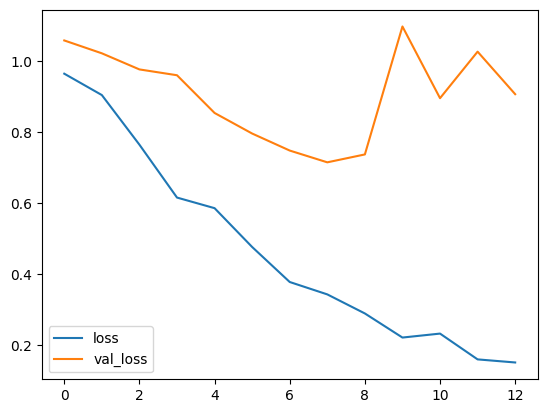

In [94]:
df_history[['loss', 'val_loss']].plot()


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<Axes: >

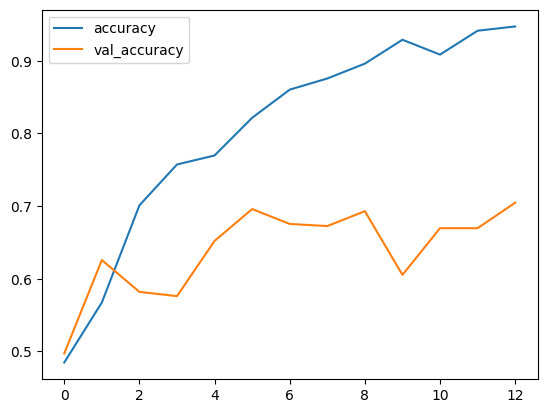

In [95]:
df_history[['accuracy', 'val_accuracy']].plot()


In [96]:
# 에측

y_pred = model.predict(x_test_sp)
y_pred[:10]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


14/14 [==============================] - 3s 37ms/step


array([[3.75679471e-02, 7.04941154e-03, 9.55382586e-01],
       [1.38332754e-01, 9.28559005e-02, 7.68811345e-01],
       [9.87968326e-01, 5.90353622e-04, 1.14412652e-02],
       [9.91222501e-01, 4.59822943e-04, 8.31775554e-03],
       [9.14581478e-01, 9.24691837e-03, 7.61716813e-02],
       [8.50651339e-02, 1.44822085e-02, 9.00452673e-01],
       [1.73503548e-01, 2.46980991e-02, 8.01798403e-01],
       [9.91985679e-01, 3.78311845e-04, 7.63600832e-03],
       [8.48076269e-02, 6.74287602e-02, 8.47763598e-01],
       [1.29464502e-02, 1.15086418e-02, 9.75544870e-01]], dtype=float32)

In [97]:
# 평가
# numpy.argmax 이용, 가장 큰 값의 인덱스 반환한 값 (class 예측) >> y_predict

y_predict = np.argmax(y_pred, axis = 1)
# axis = 1 열끼리 비교 (행 방향) 최대값 찾기 (각 샘플(행)마다 가장 높은 확률을 가진 열의 인덱스 반환)

y_predict

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


array([2, 2, 0, 0, 0, 2, 2, 0, 2, 2, 2, 0, 2, 1, 2, 2, 0, 1, 2, 0, 2, 0,
       2, 0, 0, 1, 0, 2, 2, 2, 0, 0, 2, 2, 2, 1, 2, 0, 0, 2, 0, 0, 2, 2,
       2, 2, 2, 2, 0, 0, 1, 2, 0, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 0, 2,
       2, 0, 2, 2, 2, 0, 0, 1, 2, 1, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 2, 2,
       2, 0, 2, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 2, 2, 2, 2, 0, 2,
       0, 0, 1, 2, 1, 2, 0, 2, 2, 2, 2, 2, 0, 0, 0, 2, 0, 2, 2, 2, 2, 2,
       0, 2, 2, 0, 0, 2, 2, 2, 2, 2, 0, 0, 2, 0, 0, 0, 2, 2, 1, 2, 2, 0,
       1, 2, 0, 0, 0, 0, 0, 0, 1, 2, 2, 2, 2, 2, 0, 0, 2, 0, 2, 0, 2, 2,
       2, 2, 2, 2, 0, 0, 1, 2, 0, 2, 2, 2, 0, 0, 2, 2, 2, 2, 2, 0, 2, 0,
       0, 2, 0, 0, 2, 2, 0, 2, 1, 2, 2, 2, 0, 1, 0, 0, 2, 1, 2, 2, 2, 0,
       2, 0, 0, 2, 2, 2, 0, 2, 2, 2, 2, 2, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2,
       0, 0, 1, 2, 2, 2, 2, 2, 0, 0, 2, 2, 2, 0, 2, 0, 1, 0, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 0, 1, 0, 0, 2, 0, 2, 1, 2, 2, 2, 2, 0, 2, 2, 0, 2,
       0, 1, 2, 0, 2, 1, 0, 0, 2, 2, 0, 2, 0, 0, 0,

In [98]:
y_test_val = np.argmax(y_test.values, axis=1)

y_test_val

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


array([2, 2, 2, 0, 2, 0, 2, 2, 1, 2, 2, 0, 2, 2, 1, 2, 2, 2, 1, 0, 0, 0,
       1, 0, 2, 0, 0, 2, 2, 2, 0, 0, 2, 2, 0, 1, 0, 2, 0, 2, 2, 0, 2, 0,
       2, 0, 2, 2, 0, 0, 2, 2, 0, 0, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 0, 2,
       2, 0, 2, 2, 2, 2, 0, 2, 2, 0, 0, 2, 2, 2, 1, 0, 1, 1, 0, 0, 2, 2,
       2, 2, 2, 0, 0, 2, 0, 0, 2, 2, 0, 2, 2, 1, 1, 0, 2, 0, 0, 0, 0, 2,
       0, 0, 2, 2, 1, 0, 0, 1, 2, 2, 2, 0, 2, 2, 2, 1, 2, 0, 2, 2, 2, 2,
       0, 2, 2, 0, 0, 0, 2, 2, 0, 1, 0, 0, 2, 2, 0, 0, 1, 2, 1, 2, 2, 0,
       1, 2, 0, 0, 0, 0, 2, 0, 2, 1, 0, 0, 2, 2, 2, 2, 2, 2, 2, 0, 2, 0,
       0, 2, 2, 2, 0, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 2, 2, 0, 2, 0, 2, 0,
       2, 2, 0, 1, 2, 2, 0, 2, 1, 2, 2, 2, 0, 1, 0, 0, 2, 1, 2, 2, 0, 0,
       2, 0, 0, 1, 1, 2, 0, 2, 2, 2, 0, 2, 2, 0, 2, 0, 2, 2, 0, 2, 2, 2,
       0, 0, 0, 2, 0, 2, 0, 0, 1, 2, 2, 0, 2, 0, 0, 0, 2, 1, 2, 2, 2, 0,
       2, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 2, 2, 2, 0, 2, 0, 2,
       0, 1, 2, 0, 1, 1, 0, 2, 2, 2, 2, 0, 0, 0, 2,

In [99]:
# 실제값과 예측값 비교 > 맞춘 값의 평균 확인

(y_test_val == y_predict).mean()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


0.6588785046728972

In [100]:
test_loss, test_acc = model.evaluate(x_test_sp, y_test)


 1/14 [=>............................] - ETA: 0s - loss: 1.3196 - accuracy: 0.5625

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


14/14 [==============================] - 1s 40ms/step - loss: 1.0411 - accuracy: 0.6589


In [101]:
print('loss(test): ', test_loss)
print()
print('acc(test): ', test_acc)

loss(test):  1.0411003828048706

acc(test):  0.65887850522995


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [102]:
# argmax()

arr = np.array([  [0.1, 0.7, 0.2],
                  [0.3, 0.4, 0.3],
                  [0.2, 0.1, 0.7] ])

# 각 열(행 방향 비교)에서 가장 큰 값의 인덱스 값을 반환
np.argmax(arr, axis = 1)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


array([1, 1, 2])

In [103]:
np.argmax(arr)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


1